In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

from objloader import *

pygame 2.1.2 (SDL 2.0.16, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Realidade Aumentada
O objetivo deste trabalho é detectar e localizar alvos nos quadros (frames) de um vídeo e inserir na cena objetos tridimensionais acima de cada alvo detectado. Para este trabalho, o objeto tridimensional será um cubo tridimensional e um modelo 3D (o Pikachu). Para isso, o trabalho será divido nas seguintes etapas:

1. Estimativa dos parâmetros intrínsecos da câmera
2. Detecção do alvo nos frames do vídeo
    * Transformar no espaço de cores em cinza
    * Aplicar redução de ruído
    * Binarizar a imagem
    * Encontrar os contornos
    * Filtrar contornos
    * Encontrar a rotação do alvo que melhor corresponde ao contorno encontrado
3. Estimativa da Pose
4. Renderização do Cubo e do Pikachu nos frames do vídeo
    * Setup do OpenGL
    * Renderização da imagem de fundo
    * Renderização dos objetos da cena
    

## Estimativa dos parâmetros intrísecos da câmera
Para realizar essa etapa, será utilizado o Octave. Primeiramente, adicionamos o toolbox de camera calibration no Octave com o comando
```bash
addpath("<path>/<to>/<toolbox>/<parent_folder>/camera_calibration_toolbox_octave-master")
```
Então, navegamos para a pasta onde estão as imagens que queremos utilizar para a calibração de câmera. No nosso caso, são os frames do vídeo de entrada. Foram utilizados 20 frames para realizar a calibração. Após carregadas as imagens, extraimos as quinas utilizando a ferramenta visual do toolbox. Feito isso, o toolbox já possui todos os parametros necessários para realizar a calibração. Obtemos, então, os seguintes resultados:


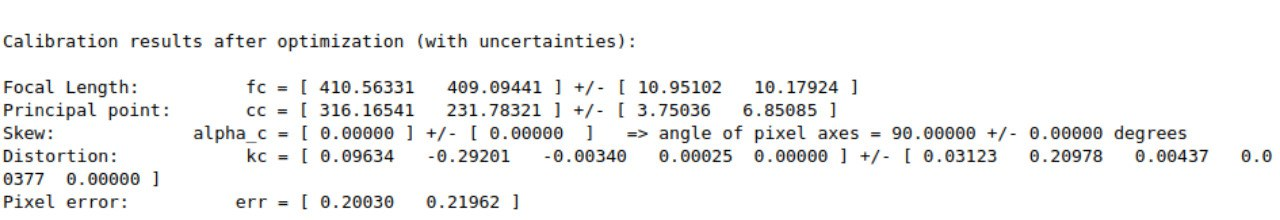

In [2]:

# https://ibb.co/YcpbjxK
# https://ibb.co/ZfB7jsm
# https://ibb.co/0n29xg3

img = Image.open("./results/intrisics.jpeg")
img

In [3]:
CAMERA_INTRISICS = np.array([
    [410.56331, 0.0, 316.16541],
    [0.0, 409.09441, 231.78321],
    [0.0, 0.0, 1.0]
])

KC = np.array([0.09634, -0.29201, -0.00340, 0.00025, 0.0])

## Detecção dos Alvos nos Frames do Vídeo
Para a realização dessa etapa, precisamos aplicar algumas transformções na imagem de entrada (cada frame do vídeo). A primeira delas é transformar o espaço de cores de BGR (padrão quando carregamos a imagem) para GRAY (em escala de cinza). Trabalhar com apenas um espaço de cor é mais simples e permite que os passos seguintes sejam realizados. Após isso, aplicamos a função do OpenCV `bilateralFilter`, que é um filtro para redução de ruido. O filtro bilateral pode reduzir muito bem o ruído indesejado, mantendo as bordas bastante nítidas. Essa etapa é importante para que a deteccção de contorno funcione melhor. O próximo passo é binarizar a imagem. O processo de binarização converte cada valor de pixel em 1 (branco) ou 0 (preto), a depender do valor do pixel. A aplicação das funções descritas acima foram englobadas na função `binarize_img`, implementada abaixo.  


In [4]:
def binarize_img(img, use_canny=True):
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    b_filter = cv2.bilateralFilter(gray_scale, 9, 50, 50, cv2.BORDER_DEFAULT)
    if use_canny:
        b_filter = cv2.Canny(b_filter, 30, 200)
    _, binarized = cv2.threshold(b_filter, 127, 255, cv2.THRESH_BINARY)
    return binarized

Desse modo, "preparamos" a imagem para que possamos aplicar a função `findContours` da OpenCV. Como se espera, ela retorna os contornos encontrados na imagem. Os contornos encontrados contém os alvos contidos no frame do vídeo, porém contém também outros contornos. Portanto, é necessário filtrar os contornos, de forma a retornar apenas aqueles que representam um alvo. Com essa finalidade foi criada a função `filter_contours`(implementada abaixo). Ela utliza funções da OpenCV para calcular o perímetro e a forma de cada retorno, selecionando aqueles que melhor se adequem ao alvo esperado. Ainda assim, alguns contronos que não alvos ainda podem ser identificados como indicado na imagem abaixo (repare o trapézio no canto superior direito). Isso porque ainda é necessário fazer um casamento dos contornos selecionados com o alvo especificado.

In [5]:
def find_contours(binary_img):
    contours, _ = cv2.findContours(image=binary_img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    return contours

In [6]:
def filter_contours(contours):
    MIN_AREA = 1000
    MAX_AREA = 10000
    filtered = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, perimeter*0.03, True)
        if (len(contour) == 4 and cv2.isContourConvex(contour) and cv2.contourArea(contour) > MIN_AREA and cv2.contourArea(contour) < MAX_AREA):
            filtered.append(contour)
        
    return filtered

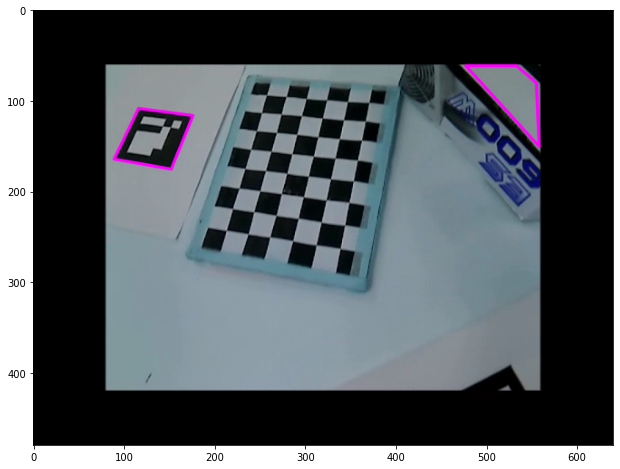

In [7]:
video = cv2.VideoCapture('entrada.mp4')
ok, nxt_frame = video.read()

for i in range(0,768):
    ok, nxt_frame = video.read()

bin = binarize_img(nxt_frame, use_canny=False)
contours = find_contours(bin)
contours = filter_contours(contours)

img = nxt_frame.copy()

cnt_image = cv2.drawContours(image=img, contours=contours, contourIdx=-1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)

plt.subplots(figsize=(15, 8))
plt.imshow(cnt_image, cmap='gray')


Para realizar o casamento dos contornos com o alvo, carregamos a imagem do alvo:

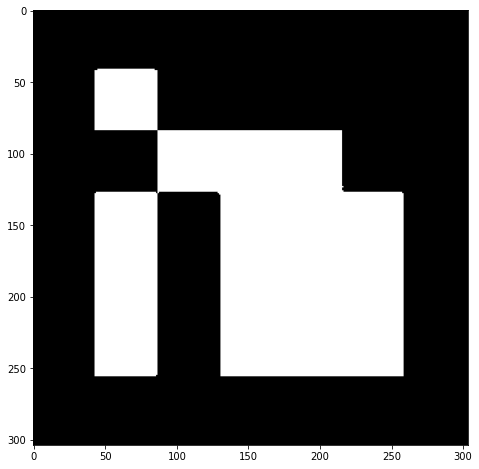

In [8]:
target = cv2.imread('alvo.jpg')
target = binarize_img(target, use_canny=False)
plt.subplots(figsize=(15, 8))
plt.imshow(target, cmap='gray')

A próxima etapa consiste em aplicar a função `match_contours` implementada abaixo. Para cada contorno, ela encontra a matriz de homografia entre ele e os pontos de canto do alvo. Então, aplica a transformação perspectiva na frame do vídeo, utilizando a função `warpPerspective` da OpenCV. Após isso, rotacionamos a imagem obtida em quatro ângulos diferentes (0, 90, 180 e 270) e verificamos qual deles possui maior semelhança com o alvo. Para isso, utilizamos uma métrica de erro que calcula a diferença absoluta entre o alvo original e o encontrado. Retornamos o menor erro encontrado e o ângulo no qual ele representa. Repare que a função `find_matches` aplica a `match_contour` para cada contorno encontrado, e define um erro máximo que pode-se ter para que um contorno seja considerado um alvo. Dessa forma, eliminamos, por exemplo, o contorno em forma de trapézio mostrado acima. 

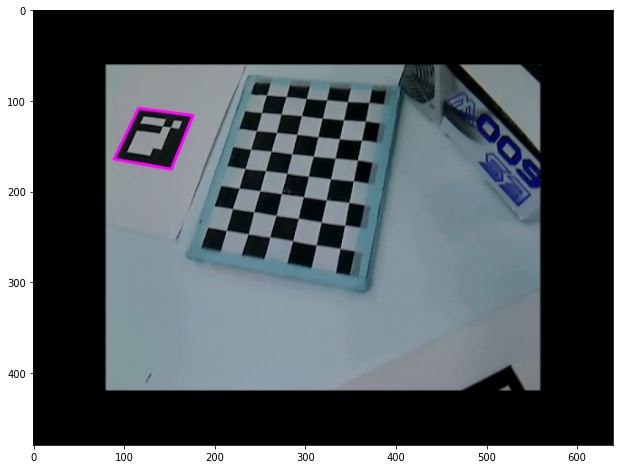

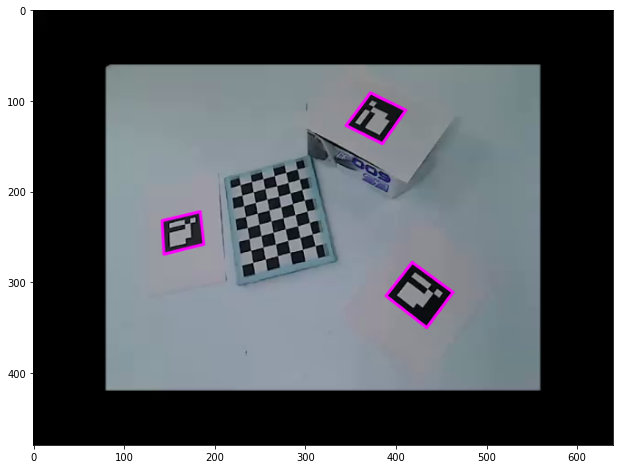

In [9]:
def match_contour(bin_frame, contour):
    target_height, target_width = target.shape
    target_corners = np.array([[0,0], [target_width-1, 0], [target_width-1, target_height-1], [0, target_height-1]])
    homo, _ = cv2.findHomography(contour, target_corners, cv2.RANSAC, 5.0)
    proj = cv2.warpPerspective(bin_frame,homo,(target_width, target_height), flags=cv2.INTER_LINEAR)

    min_error = float("inf")
    best_angle = []

    for _, angle in enumerate([0,90,180,270]):
        rotation_matrix = cv2.getRotationMatrix2D((proj.shape[1]/2, proj.shape[0]/2), angle, 1)
        rotated = cv2.warpAffine(proj, rotation_matrix, (proj.shape[0], proj.shape[1]))
        error = np.sum(np.abs(rotated.astype("float") - target.astype("float")))
        error /= float(rotated.shape[0] * rotated.shape[1])*256

        if error < min_error:
            best_angle = angle
            min_error = error
        
    return best_angle, min_error


def find_matches(bin_frame, contours):
    MAX_ERR = 0.1
    matches_angles = []
    selected_contours = []
    for contour in contours:
        angle, err = match_contour(bin_frame, contour)
        if err < MAX_ERR:
            selected_contours.append(contour)
            matches_angles.append(angle)
    
    return selected_contours, matches_angles


def show_contours(frame_number):
    video = cv2.VideoCapture('entrada.mp4')
    ok, nxt_frame = video.read()

    for i in range(0,frame_number):
        ok, nxt_frame = video.read()

    bin = binarize_img(nxt_frame, use_canny=False)
    contours = find_contours(bin)
    contours = filter_contours(contours)
    contours, _ = find_matches(bin, contours)

    cnt_image = cv2.drawContours(image=nxt_frame, contours=contours, contourIdx=-1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    plt.subplots(figsize=(15, 8))
    plt.imshow(cnt_image, cmap='gray')

contours, matches_angles = find_matches(bin, contours)
show_contours(768)
show_contours(0)


## Estimativa da Pose
Para estimar a pose para cada contorno, foi implementada a função `get_poses` que aplica a função da OpenCV `solvePnP`. Dessa forma, obtemos as matrizes de rotação e translação (parâmetros extrínsecos). As funções `draw_each_pose` e `draw_pose` são auxiliares para que seja possível mostrar de formar visual os resultados obtidos após a aplicação de `get_poses`.

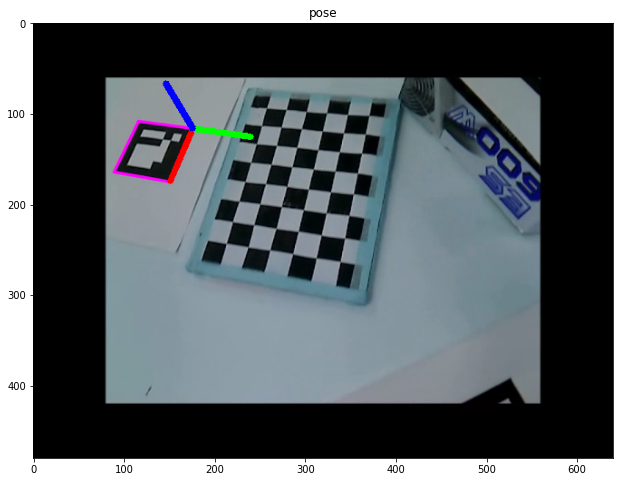

In [10]:
def get_poses(contours, matches_angles):
    object_points = {
        0: np.array([[0,0,0], [1,0,0], [1,-1,0], [0,-1,0]], dtype=np.float64),
        90: np.array([[0,-1,0], [0,0,0], [1,0,0], [1,-1,0]], dtype=np.float64),
        180: np.array([[1,-1,0], [0,-1,0], [0,0,0], [1,0,0]], dtype=np.float64),
        270: np.array([[1,0,0], [1,-1,0], [0,-1,0], [0,0,0]], dtype=np.float64)
    }

    poses = []
    for idx in range(len(contours)):
        _, rotation, translation = cv2.solvePnP(object_points[matches_angles[idx]], contours[idx].astype(float), CAMERA_INTRISICS, KC)
        poses.append((rotation, translation))

    return poses

def draw_each_pose(img, corder_idx, corners, imgpts):
    corner = tuple(corners[corder_idx].astype(int).ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].astype(int).ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].astype(int).ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].astype(int).ravel()), (0,0,255), 5)
    return img

def draw_poses(frame, contours, matches_angles, poses):
    image = frame.copy()
    for i, con in enumerate(contours):
        axis = np.float32([[1,0,0], [0,1,0], [0,0,1]])
        proj, _ = cv2.projectPoints(axis, poses[i][0], poses[i][1], CAMERA_INTRISICS, KC)
        image = draw_each_pose(image, int(matches_angles[i]/90), con, proj)
    plt.subplots(figsize=(15, 8))
    plt.imshow(image, cmap='gray'), plt.title("pose")
    plt.show()


poses = get_poses(contours, matches_angles)
cnt_image = cv2.drawContours(image=nxt_frame, contours=contours, contourIdx=-1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)
draw_poses(nxt_frame, contours, matches_angles, poses)

## Renderização do Cubo e do Pikachu nos frames do vídeo
Para realizar a renderização e rotação do pikachu e renderização do cubo na cena, será utilizado o OpenGL. Primeiramente são definidas algumas variavéis globais que serão utilizadas na hora de renderizar cada frame do vídeo. Os parâmetros e configurações inicias do OpenGL são definidos na função `start` e `initOpenGL`. Tais configurações definem o nome e dimensão da janela de renderização, assim como o campo de visão no sistema de coordenadas do mundo (a partir do field of view especificado), entre outras configurações. Além disso, a função `glutIdleFunc` define a função que será chamada quando eventos não estão sendo processados. É nessa função que a lógica de cálculo da posição e renderização dos objetos e background da cena será implementada. 

In [11]:
global _video
_video = cv2.VideoCapture('entrada.mp4')

global pikachu
pikachu = None

global frame_counter
frame_counter = 0

global pikachu_angle
pikachu_angle = 0


A função `displayCallback` é então passada como parâmetro da função `glutIdleFunc`. Ela controla o que será exibido em cada frame do vídeo. A primeira etapa é renderizar o background a partir do frame atual do vídeo. A função `renderBackground` possui essa funcionalidade. Ela recebe como parametro um frame do vídeo e mostra ele na viewport como imagem de fundo. 

In [12]:
def renderBackground(img):
    width, height = (640, 480)
    textId = glGenTextures(1)

    glBindTexture(GL_TEXTURE_2D, textId)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_LINEAR)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_LINEAR)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGB, width, height, 0, GL_BGR, GL_UNSIGNED_BYTE, img)

    glDepthMask(GL_FALSE)
    glMatrixMode(GL_PROJECTION)
    glPushMatrix()
    glLoadIdentity()
    glOrtho(0, width, height, 0.0, 0.0, 1)
    
    glEnable(GL_TEXTURE_2D)
    glBindTexture(GL_TEXTURE_2D, textId)
    glMatrixMode(GL_MODELVIEW)
    glPushMatrix()
    
    glBegin(GL_QUADS)
    
    glTexCoord2f(0, 0) 
    glVertex2f(0, 0) 
    
    glTexCoord2f(1, 0)
    glVertex2f(width, 0) 
    
    glTexCoord2f(1, 1)
    glVertex2f(width, height) 
    
    glTexCoord2f(0, 1)
    glVertex2f(0, height) 
    
    glEnd()
    
    glPopMatrix()
    glMatrixMode(GL_PROJECTION)
    glPopMatrix()
    glMatrixMode(GL_MODELVIEW)
    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)
    glFlush()




Então, cada frame do vídeo é exibido na tela. O próximo passo é calcular as poses para cada um dos alvos identificados nas frames do vídeo. Portando, o mesmo pipeline explicado e mostrado anteriormente é aplicado a cada frame: Binariza a imagem, encontra os contornos, filtra os contornos, encontra a melhor match com o alvo, e por fim, estima as poses. Para cada pose, é calculada a matriz de perspectiva com a ajuda da função `Rodrigues` da OpenCV. A função `Rodrigues` converte uma matriz de rotação para um vetor de rotação. Desse modo, podemos combinar as matrizes de rotação e translação de cada pose para se obter a matriz de perspectiva. Com a matriz de perspectiva calculada, passamos para a etapa de renderização dos objetos da cena. A função `object3D` implementada abaixo é encarregada de renderizar 4 objetos:

* A cabeça da seta de orientação (a partir de um cone)
* O corpo da seta de orientção (a partir de um cilindro)
* O cubo
* O pikachu

A função `object3D` aplica a matriz de perspectiva calculada para cada alvo encontrado e então renderiza os objetos a partir dela. Desse modo, os objetos são renderizados em cima do alvo.

In [13]:
def object3D(mat, pikachu, pikachu_angle):
    glPushMatrix()
    glLoadMatrixf(mat)
    
    # render arrow head
    glPushMatrix()
    glTranslatef(0.1, 1, .1)
    glRotate(-90, 1, 0, 0)
    glutWireCone(.15,.8, 10, 6)
    glPopMatrix()

    # render arrow line
    glPushMatrix()
    quadObj = gluNewQuadric()
    gluQuadricDrawStyle(quadObj, GLU_FILL);
    gluQuadricNormals(quadObj, GLU_SMOOTH);
    glRotate(-90, 1, 0, 0)
    glTranslate(0,0.05,.1)
    gluCylinder(quadObj, 0.01 , 0.01, 0.9 ,32,1)
    glPopMatrix()
    
    glTranslatef(0, -.1, 0)
    
    # render a cube
    glPushMatrix()
    glTranslatef(0, -0.35, 0)
    glutWireCube(1)
    glPopMatrix()

    # render the pikachu model
    glPushMatrix()
    glScalef(.4, .4, .4)
    glTranslatef(0, -0.35, 0)
    glRotate(-pikachu_angle, 0, 0, 1)
    glCallList(pikachu.gl_list)
    glPopMatrix()
    
    glPopMatrix()

In [14]:
def initOpenGL(dimensions):

    (width, height) = dimensions
    
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
 
    fovy = 57
    aspect = (width)/(height)
    gluPerspective(fovy, aspect, 0.1, 100.0)

    
def displayCallback():
    global _video
    global frame_counter
    global pikachu
    global pikachu_angle

    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    if frame_counter == _video.get(cv2.CAP_PROP_FRAME_COUNT):
        frame_counter = 0
        _video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    ok, nxt_frame = _video.read()
    frame_counter += 1

    renderBackground(nxt_frame)
    
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glEnable(GL_TEXTURE_2D)
    
    # load pikachu model if it's not already loaded
    if pikachu == None:
        pikachu = OBJ("Pikachu.obj", swapyz=True)

    if ok:
        bin = binarize_img(nxt_frame, use_canny=False)
        contours = find_contours(bin)
        contours = filter_contours(contours)
        contours, matches_angles = find_matches(bin, contours)
        poses = get_poses(contours, matches_angles)
        
        #draw_poses(nxt_frame, contours, matches_angles, poses)
        
        for pose in poses:
            rotation = pose[0]
            translation = pose[1]
    
            rodr, _ = cv2.Rodrigues(rotation)
            mat = np.append(rodr, translation, axis=1)
            mat = np.append(mat, [[0, 0, 0, 1]], axis=0)
            mat[1:3, 0:4] *= -1
            mat = np.transpose(mat).astype('float64')

            if pikachu_angle == 361:
                pikachu_angle = 0

            object3D(mat, pikachu, pikachu_angle)
    
    pikachu_angle += 0.5
    glutSwapBuffers()    
    

def idleCallback():
    glutPostRedisplay()
    
    
def start():
    dimensions = (640, 480)
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
    glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
    glutInitWindowSize(*dimensions)
    window = glutCreateWindow(b'Realidade Aumentada - Pikachu!')
    
    initOpenGL(dimensions)
    
    glutDisplayFunc(displayCallback)
    glutIdleFunc(idleCallback)
    
    glutMainLoop()

start()

Desse modo, então, atingimos o objetivo de renderizar os objetos em cima dos alvos encontrados em cada frame do vídeo. Para cada frame, o Pikachu é rotacionado em 0.5 graus(utiliza a variável global `pikachu_angle`). Exemplos dos resultados obtidos podem ser visualizados abaixo.

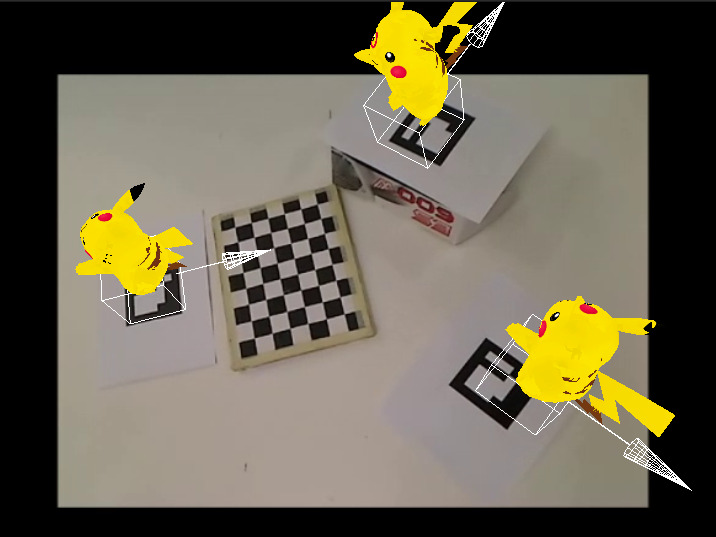

In [15]:
img = Image.open("./results/pikachu_1.jpeg")
img

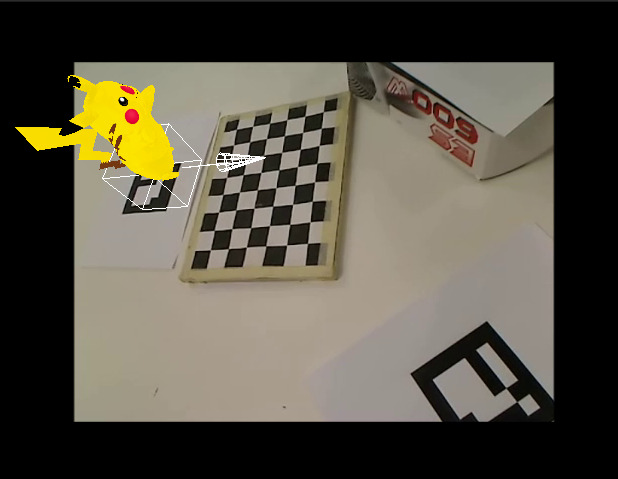

In [16]:
img = Image.open("./results/pikachu_2.jpeg")
img

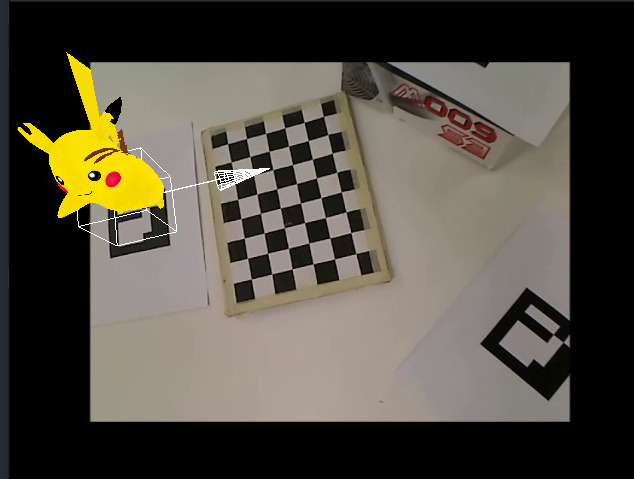

In [20]:
img = Image.open("./results/pikachu_3.jpeg")
img